In [19]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *

import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [9]:
df = pd.read_csv("file:///Users/aidancampos/Downloads/Tweets.csv")

df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [11]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [13]:
# Define a list of stopwords
stopwords_list = ['a', 'an', 'the', 'in', 'on', 'at', 'for', 'to', 'and', 'or', 'is', 'are', 'was', 'were', 'am']

# Function to clean and preprocess text
def preprocess_text(text):
    # Remove special characters, URLs, mentions, and punctuation
    text = re.sub(r'http\S+|www\S+|https\S+|@\w+|#', '', str(text))
    text = re.sub(r'[^\w\s]', '', str(text))
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenization
    tokens = text.split()  # Basic split-based tokenization
    
    # Remove stopwords
    tokens = [token for token in tokens if token not in stopwords_list]
    
    # Join tokens back together
    cleaned_text = ' '.join(tokens)
    return cleaned_text

# Apply preprocessing to the specified column ('text_column')
df['Cleaned_Text'] = df['text'].apply(preprocess_text)

# Display the original and cleaned text
print(df[['text', 'Cleaned_Text']])

                                                    text  \
0                    @VirginAmerica What @dhepburn said.   
1      @VirginAmerica plus you've added commercials t...   
2      @VirginAmerica I didn't today... Must mean I n...   
3      @VirginAmerica it's really aggressive to blast...   
4      @VirginAmerica and it's a really big bad thing...   
...                                                  ...   
14635  @AmericanAir thank you we got on a different f...   
14636  @AmericanAir leaving over 20 minutes Late Flig...   
14637  @AmericanAir Please bring American Airlines to...   
14638  @AmericanAir you have my money, you change my ...   
14639  @AmericanAir we have 8 ppl so we need 2 know h...   

                                            Cleaned_Text  
0                                              what said  
1          plus youve added commercials experience tacky  
2       i didnt today must mean i need take another trip  
3      its really aggressive blast obnoxiou

In [21]:
# Splitting the data
X = df['Cleaned_Text']
y = df['airline_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature extraction using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Define models
models = [
    ('Naive Bayes', MultinomialNB()),
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Random Forest', RandomForestClassifier()),
    ('Support Vector Machine', SVC())
]

best_model = None
best_score = 0

# Evaluate models using cross-validation
for name, model in models:
    # Cross-validation scores
    scores = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
    mean_score = scores.mean()
    std_score = scores.std()
    
    print(f"{name} Cross-Validation Accuracy: {mean_score:.4f} (+/- {std_score * 2:.4f})")
    
    if mean_score > best_score:
        best_score = mean_score
        best_model = model

# Train the best performing model
best_model.fit(X_train_tfidf, y_train)

# Predictions on test data
predictions = best_model.predict(X_test_tfidf)

# Model evaluation
accuracy = accuracy_score(y_test, predictions)
print(f"\nBest Model ({type(best_model).__name__}) Test Accuracy: {accuracy:.4f}\n")

Naive Bayes Cross-Validation Accuracy: 0.6692 (+/- 0.0059)
Logistic Regression Cross-Validation Accuracy: 0.7930 (+/- 0.0077)
Random Forest Cross-Validation Accuracy: 0.7561 (+/- 0.0106)
Support Vector Machine Cross-Validation Accuracy: 0.7835 (+/- 0.0097)

Best Model (LogisticRegression) Test Accuracy: 0.8070



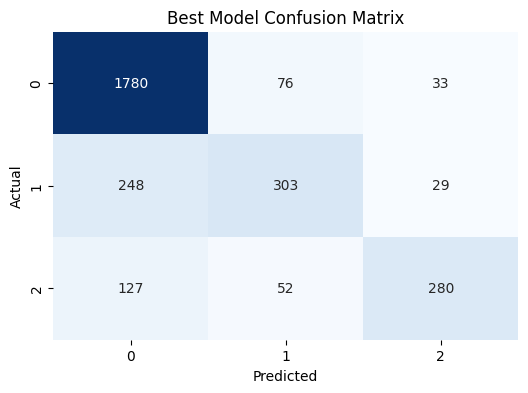

Best Model Classification Report:
              precision    recall  f1-score   support

    negative       0.83      0.94      0.88      1889
     neutral       0.70      0.52      0.60       580
    positive       0.82      0.61      0.70       459

    accuracy                           0.81      2928
   macro avg       0.78      0.69      0.73      2928
weighted avg       0.80      0.81      0.80      2928



In [20]:
# Confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Best Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print("Best Model Classification Report:")
print(classification_report(y_test, predictions))